# Spectral analysis with energy-dependent directional cuts

## Prerequisites 

- Understanding the basic data reduction performed in a [1D analysis](spectral_analysis.ipynb);
- understanding the difference between a [point-like](https://gamma-astro-data-formats.readthedocs.io/en/latest/irfs/point_like/index.html) and a [full-enclosure](https://gamma-astro-data-formats.readthedocs.io/en/latest/irfs/full_enclosure/index.html) IRF.

## Context

As already explained in these tutorials, in a [1D spectral analysis](spectral_analysis.ipynb) the background is estimated from the field of view of the observation. In particular, the source and background events are counted within a circular ON region enclosing the source. The background to be subtracted is then estimated from one or more OFF regions with an expected background rate similar to the one in the ON region (i.e. from regions with similar acceptance).

*Full-containment* IRFs have no directional cut applied, when employed for a 1D analysis, it is required to apply a correction to the IRF accounting for flux leaking out of the ON region. This correction is typically obtained by integrating the PSF within the ON region.

When computing a *point-like* IRFs, a directional cut around the assumed source position is applied to the simulated events. For this IRF type, no PSF component is provided. The size of the ON and OFF regions used for the spectrum extraction should then reflect this cut, since a response computed within a specific region around the source is being provided.

The directional cut is typically an angular distance from the assumed source position, $\theta$. 
The [gamma-astro-data-format](https://gamma-astro-data-formats.readthedocs.io/en/latest/) specifications offer two different ways to store this information:
* if the same $\theta$ cut is applied at all energies and offsets, [a `RAD_MAX` keyword](https://gamma-astro-data-formats.readthedocs.io/en/latest/irfs/point_like/#rad-max) is added to the header of the data units containing IRF components. This should be used to define the size of the ON and OFF regions;
* in case an energy- (and offset-) dependent $\theta$ cut is applied, its values are stored in additional `FITS` data unit, named [`RAD_MAX_2D`](https://gamma-astro-data-formats.readthedocs.io/en/latest/irfs/point_like/#rad-max-2d). 

`Gammapy` provides a class to automatically read this values, `~gammapy.irf.RadMax2D`, for both cases (fixed or energy-dependent $\theta$ cut). In this notebook we will focus on how to perform a spectral extraction with a point-like IRF with an energy-dependent $\theta$ cut. We remark that in this case a `~regions.PointSkyRegion` (and not a `~regions.CircleSkyRegion`) should be used to define the ON region. If a geometry based on a `~regions.PointSkyRegion` is fed to the spectra and the background `Makers`, the latter will automatically use the values stored in the `RAD_MAX` keyword / table for defining the size of the ON and OFF regions.

Beside the definition of the ON region during the data reduction, the remaining steps are identical to the other [1D spectral analysis example](spectral_analysis.ipynb), so we will not detail the data reduction steps already presented in the other tutorial.

**Objective: perform the data reduction and analysis of 2 Crab Nebula observations of MAGIC and fit the resulting datasets.**

## Introduction

We load two MAGIC observations in the [gammapy-data](https://github.com/gammapy/gammapy-data) containing IRF component with a $\theta$ cut.

We define the ON region, this time as a `PointSkyRegion` instead of a `CircleSkyRegion`, i.e. we specify only the center of our ON region. We create a `RegionGeom` adding to the region the estimated energy axis of the `~gammapy.datasets.SpectrumDataset` object we want to produce. The corresponding dataset maker will automatically use the $\theta$ values in `~gammapy.irf.RadMax2D` to set the appropriate ON region sizes (based on the offset on the observation and on the estimated energy binning).

In order to define the OFF regions it is recommended to use a `~gammapy.makers.WobbleRegionsFinder`, that uses fixed positions for the OFF regions. In the different estimated energy bins we will have OFF regions centered at the same positions, but with changing size. As for the `SpectrumDataSetMaker`, the `BackgroundMaker` will use the values in `~gammapy.irf.RadMax2D` to define the sizes of the OFF regions.

Once the datasets with the ON and OFF counts are created, we can perform a 1D likelihood fit, exactly as illustrated in the previous example.

## Setup

As usual, we'll start with some setup ...

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
# Check package versions
import gammapy
import numpy as np
import astropy
import regions

print("gammapy:", gammapy.__version__)
print("numpy:", np.__version__)
print("astropy", astropy.__version__)
print("regions", regions.__version__)

gammapy: 0.20
numpy: 1.22.3
astropy 5.0.4
regions 0.5


In [3]:
import astropy.units as u
from astropy.coordinates import SkyCoord
from regions import PointSkyRegion
from gammapy.data import DataStore
from gammapy.maps import MapAxis, RegionGeom, Map
from gammapy.modeling import Fit
from gammapy.datasets import (
    Datasets,
    SpectrumDataset,
    SpectrumDatasetOnOff,
)
from gammapy.modeling.models import (
    create_crab_spectral_model,
    SkyModel,
    LogParabolaSpectralModel,
)
from gammapy.makers import (
    SpectrumDatasetMaker,
    WobbleRegionsFinder,
    ReflectedRegionsBackgroundMaker,
    SafeMaskMaker,
)
from gammapy.utils.scripts import make_path
from gammapy.visualization import plot_spectrum_datasets_off_regions

## Load data

We load the two MAGIC observations of the Crab Nebula containing the `RAD_MAX_2D` table.

In [4]:
data_store = DataStore.from_dir("$GAMMAPY_DATA/magic/rad_max/data")
observations = data_store.get_observations(
    required_irf=["aeff", "edisp", "rad_max"]
)

A `RadMax2D` attribute, containing the `RAD_MAX_2D` table, is automatically loaded in the observation. As we can see from the IRF component axes, the table has a single offset value and 28 estimated energy values.

In [5]:
rad_max = observations["5029747"].rad_max
print(rad_max)

RadMax2D
--------

  axes  : ['energy', 'offset']
  shape : (20, 1)
  ndim  : 2
  unit  : deg
  dtype : >f4



We can also plot the rad max value against the energy:

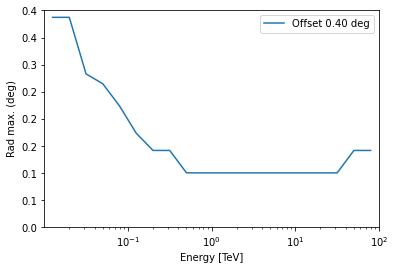

In [6]:
rad_max.plot_rad_max_vs_energy();

## Define the ON region

To use the `RAD_MAX_2D` values to define the sizes of the ON and OFF regions **it is necessary to specify the ON region as a [`PointSkyRegion`](https://astropy-regions.readthedocs.io/en/stable/api/regions.PointSkyRegion.html).**

In [7]:
target_position = SkyCoord(ra=83.63, dec=22.01, unit="deg", frame="icrs")
on_region = PointSkyRegion(target_position)

## Run data reduction chain

We begin with the configuration of the dataset maker classes:

In [8]:
# true and estimated energy axes
energy_axis = MapAxis.from_energy_bounds(
    50, 1e5, nbin=5, per_decade=True, unit="GeV", name="energy"
)
energy_axis_true = MapAxis.from_energy_bounds(
    10, 1e5, nbin=10, per_decade=True, unit="GeV", name="energy_true"
)

# geometry defining the ON region and SpectrumDataset based on it
geom = RegionGeom.create(region=on_region, axes=[energy_axis])

dataset_empty = SpectrumDataset.create(
    geom=geom, energy_axis_true=energy_axis_true
)

The `SpectrumDataset` is now based on a geometry consisting of a single coordinate and an estimated energy axis. The `SpectrumDatasetMaker` and `ReflectedRegionsBackgroundMaker` will take care of producing ON and OFF with the proper sizes, automatically adopting the $\theta$ values in `Observation.rad_max`.

As explained in the introduction, we use a `WobbleRegionsFinder`, to determine the OFF positions. The parameter `n_off_positions` specifies the number of OFF regions to be considered.

In [9]:
dataset_maker = SpectrumDatasetMaker(
    containment_correction=False, selection=["counts", "exposure", "edisp"]
)

# tell the background maker to use the WobbleRegionsFinder, let us use 1 off
region_finder = WobbleRegionsFinder(n_off_regions=3)
bkg_maker = ReflectedRegionsBackgroundMaker(region_finder=region_finder)

# use the energy threshold specified in the DL3 files
safe_mask_masker = SafeMaskMaker(methods=["aeff-default"])

In [10]:
%%time
datasets = Datasets()

# create a counts map for visualisation later...
counts = Map.create(skydir=target_position, width=3)

for observation in observations:
    dataset = dataset_maker.run(
        dataset_empty.copy(name=str(observation.obs_id)), observation
    )
    counts.fill_events(observation.events)
    dataset_on_off = bkg_maker.run(dataset, observation)
    dataset_on_off = safe_mask_masker.run(dataset_on_off, observation)
    datasets.append(dataset_on_off)

No default upper safe energy threshold defined for obs 5029747
No default upper safe energy threshold defined for obs 5029748


CPU times: user 575 ms, sys: 22 ms, total: 597 ms
Wall time: 641 ms


No we can plot the off regions and target positions on top of the counts map:

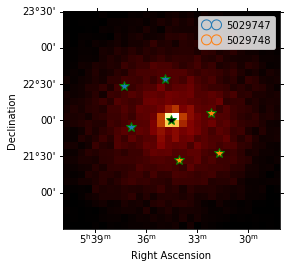

In [11]:
ax = counts.plot()
geom.plot_region(ax=ax, kwargs_point={"color": "k", "marker": "*"})
plot_spectrum_datasets_off_regions(ax=ax, datasets=datasets)

## Fit spectrum

We perform a joint likelihood fit of the two datasets.    
For this particular datasets we select a fit range between $80\,{\rm GeV}$ and $20\,{\rm TeV}$.

In [12]:
e_min = 80 * u.GeV
e_max = 20 * u.TeV

for dataset in datasets:
    dataset.mask_fit = dataset.counts.geom.energy_mask(e_min, e_max)

In [13]:
spectral_model = LogParabolaSpectralModel(
    amplitude=1e-12 * u.Unit("cm-2 s-1 TeV-1"),
    alpha=2,
    beta=0.1,
    reference=1 * u.TeV,
)
model = SkyModel(spectral_model=spectral_model, name="crab")

datasets.models = [model]

fit = Fit()
result = fit.run(datasets=datasets)

# we make a copy here to compare it later
best_fit_model = model.copy()

## Fit quality and model residuals

We can access the results dictionary to see if the fit converged:

In [14]:
print(result)

OptimizeResult

	backend    : minuit
	method     : migrad
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 223
	total stat : 23.98

CovarianceResult

	backend    : minuit
	method     : hesse
	success    : True
	message    : Hesse terminated successfully.



and check the best-fit parameters

In [15]:
datasets.models.to_parameters_table()

model,type,name,value,unit,error,min,max,frozen,is_norm,link
str4,str8,str9,float64,str14,float64,float64,float64,bool,bool,str1
crab,spectral,amplitude,4.3046e-11,cm-2 s-1 TeV-1,3.455e-12,nan,nan,False,True,
crab,spectral,reference,1.0000e+00,TeV,0.000e+00,nan,nan,True,False,
crab,spectral,alpha,2.5819e+00,,1.088e-01,nan,nan,False,False,
crab,spectral,beta,1.9574e-01,,6.591e-02,nan,nan,False,False,


A simple way to inspect the model residuals is using the function `~SpectrumDataset.plot_fit()`

(0.1, 120)

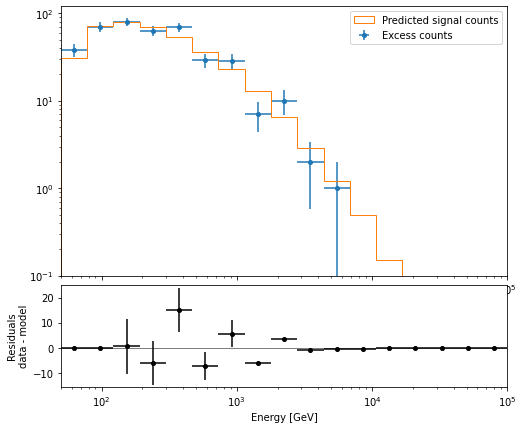

In [16]:
ax_spectrum, ax_residuals = datasets[0].plot_fit()
ax_spectrum.set_ylim(0.1, 120)

For more ways of assessing fit quality, please refer to the dedicated [modeling and fitting tutorial](../2D/modeling_2D.ipynb).

## Compare against the literature
Let us compare the spectrum we obtained against a [previous measurement by MAGIC](https://ui.adsabs.harvard.edu/abs/2015JHEAp...5...30A/abstract).

(1e-13, 1e-10)

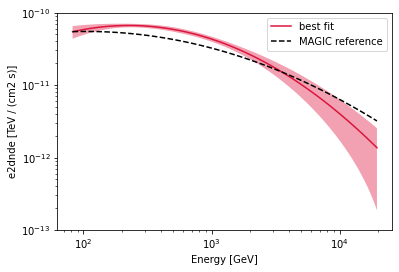

In [17]:
plot_kwargs = {
    "energy_bounds": [0.08, 20] * u.TeV,
    "sed_type": "e2dnde",
    "yunits": u.Unit("TeV cm-2 s-1"),
    "xunits": u.GeV,
}

crab_magic_lp = create_crab_spectral_model("magic_lp")

best_fit_model.spectral_model.plot(
    ls="-", lw=1.5, color="crimson", label="best fit", **plot_kwargs
)
best_fit_model.spectral_model.plot_error(
    facecolor="crimson", alpha=0.4, **plot_kwargs
)
crab_magic_lp.plot(
    ls="--", lw=1.5, color="k", label="MAGIC reference", **plot_kwargs
)

plt.legend()
plt.ylim([1e-13, 1e-10])